In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

# 1. **Рекомендации в онлайн магазине**
Есть онлайн магазин, в котором продаются мобильные телефоны и комплектующие (наушники, зарядки, чехлы и т.д.). На странице просмотра телефона был блок рекомендаций с похожими моделями и аксессуарами. В рамках сотрудничеста с компанией делающей чехлы с уникальными рисунками, решили попробовать заменить блок рекомендаций на рекламу чехлов этой компании.

**Гипотеза:**
1. изменили блок рекомендаций на рекомендации красивых чехлов
2. ожидаем что это приведёт к увеличению продаж аксессуаров
3. сможем увидеть это по метрике - средняя выручка от продажи аксессуаров

В качестве метрики взяли продажи всех аксессуаров, а не только чехлов, тк реклама именно чехлов может каннибализировать продажу других видов аксессуаров.

**Дополнительные метрики:**
- продажи чехлов - чтобы понимать, что чехлы продаются и интересны покупателям;
- продажи других аксессуаров - реклама только чехлов может каннибализировать продажи других аксессуаров;
- трафик (кол-во покупателей на кол-во сессий просмотра сайта) - вдруг наше изменение будут настолько плохим, что покупателей станет меньше;
- средний чек - возможно наше изменение стимулирует увеличение покупок чехлов, что увеличит средний чек;
- суммарные продажи телефонов и аксессуаров - может быть так, что трафик уменьшится, но средний чек увеличится, и суммарная выручка не упадёт.

**Пилот**:
- случайно разбиваем пользователей, зашедших на сайт, в контрольную или пилотную группы;
- в контрольной группе показываем старые рекомендации, в пилотной - новые;
- ждём 14 дней;
- за это время в группах оказалось по 110523 пользовательских сессии.

## Загрузим данные

Заметим, что в представленной базе данных уже проведена фильтрация сессий без покупок. Они сейчас не существенны, про их значение мы поговорим чуть позже.

In [3]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name, index_col=0)

In [4]:
data = read_database('sem2_task1.csv')

print(f'data shape : {data.shape}')
data.sample(10)

data shape : (6452, 5)


,day,cost_phones,cost_cases,cost_accessories,group
4390,6,11400,0,0,pilot
211,1,80300,900,0,control
4196,5,54300,0,0,pilot
2160,10,8100,0,0,control
6190,13,9800,0,0,pilot
1015,5,35500,2500,0,control
1227,6,41400,0,0,control
1412,6,39600,0,0,control
280,2,43300,0,0,control
4383,6,35100,0,0,pilot


Для начала мы можем посмотреть на простую, но вместе с тем красивую картинку. В пилотной группе трафик больше, чем в контрольной.

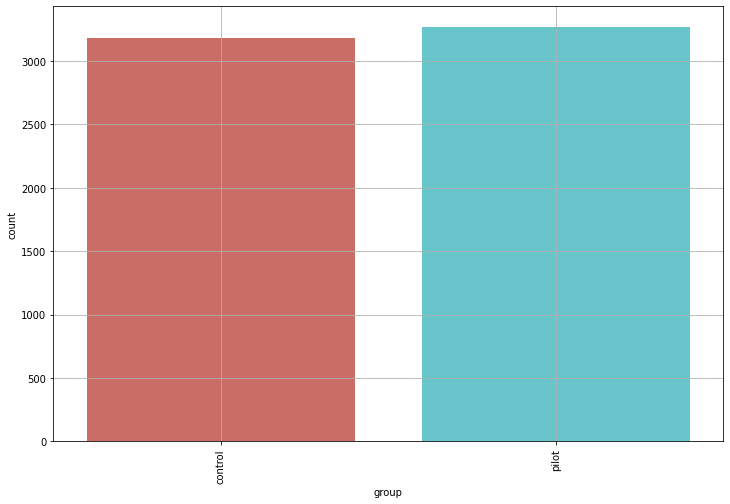

In [5]:
sns.countplot(x='group', data=data, palette='hls')
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Дашборд эксперимента

Вообще говоря нехорошо в процессе эксперимента подглядывать в данные. Тут можно долго говорить про эффект наблюдателя. Не хорошо, но иногда очень хочется.

О том как и когда имеет смысл заранее заглядывать в данные мы поговорим позже. А пока просто убедимся, что в процессе запуска эксперимента мы не допустили катострофических ошибок -- метрики не упали в ноль.

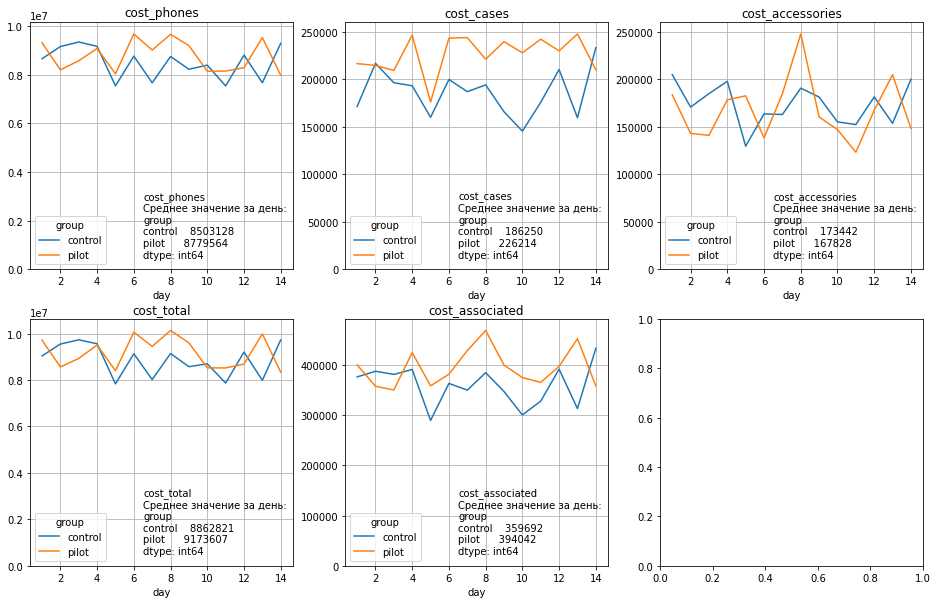

In [6]:
data_sint = data.copy()
data_sint['cost_total'] = data[['cost_phones', 'cost_cases', 'cost_accessories']].sum(axis=1)
data_sint['cost_associated'] = data[['cost_cases', 'cost_accessories']].sum(axis=1)
cost_columns = [c for c in data_sint.columns if 'cost' in c]

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

for column, ax in zip(cost_columns, ax.flatten()):
    data_groupby = data_sint.groupby(['day', 'group'])[[column]].sum().reset_index()
    data_pivot = data_groupby.pivot(index='day', columns='group', values=column)
    data_pivot.plot(ax=ax, grid=True)
    ax.set_title(column)
    y_max = data_groupby[column].max()
    ax.set_ylim([0,  y_max * 1.05])
    annotation = f'{column}\nСреднее значение за день:\n{data_pivot.mean().astype(int)}'
    ax.text(6.5, 0.05 * y_max, annotation)

## Визуальное сравнение распределений

Давайте немного подробней посмотрим на статистики. Для этого построим гистограммы по всем метрикам.

In [7]:
print(data['group'].value_counts(), '\n')

for column in data.drop('group', axis=1).columns:
    print(column)
    for group in ['control', 'pilot']:
        data_ = data[data['group']==group][column]
        print('  ', round(data_.mean(), 2), data_.nunique(), data_.min(), data_.max())

pilot      3267
control    3185
Name: group, dtype: int64 

day
   7.41 14 1 14
   7.46 14 1 14
cost_phones
   37376.39 724 4100 100800
   37622.87 735 4100 104100
cost_cases
   818.68 36 0 4200
   969.39 38 0 4000
cost_accessories
   762.39 55 0 6500
   719.19 57 0 6300


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


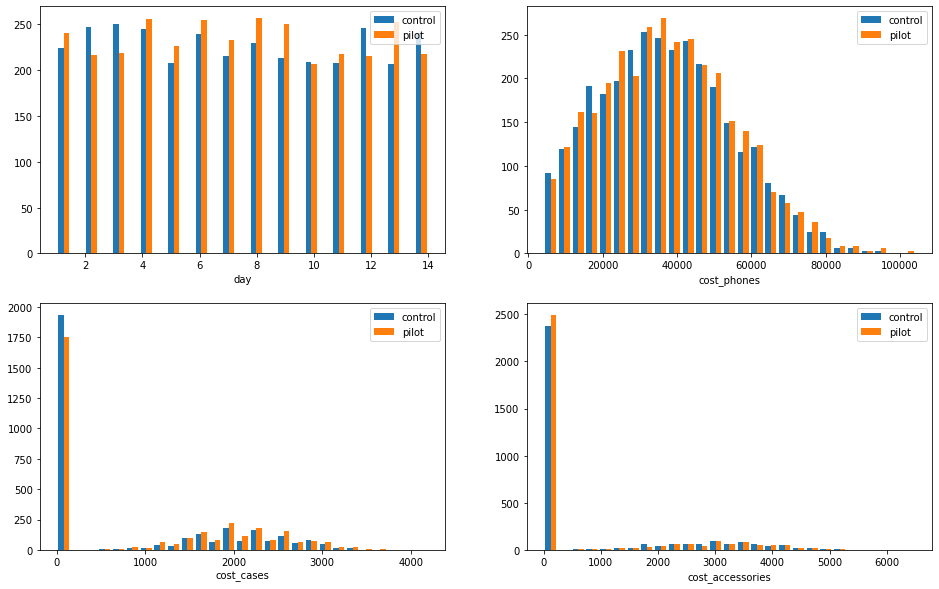

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for column, ax in zip(data.drop('group', axis=1).columns,
                      ax.flatten()):
    ax.set_xlabel(column)
    data_pilot = data[data['group'] == 'pilot'][column].values
    data_control = data[data['group'] == 'control'][column].values
    bins = np.linspace(data[column].min(), data[column].max(), 28)
    ax.hist([data_control, data_pilot], bins, label=['control', 'pilot'])
    ax.legend()
plt.show()

## Вычисление метрик

Давайте попробуем посмотреть на числа. Всё же статистика -- наука о числах, а не про картинки. Прежде всего нам надо посчитать общие значения метрик по нашим группам. Для этого в [Pandas](https://pandas.pydata.org/) есть много удобных и полезных функций. Для группировки данных нам понадобиться функция [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html):

```
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, 
    group_keys=True, squeeze=<object object>, observed=False, dropna=True)
```
а для сбора агрегированной статистики можно воспользоваться [pandas.DataFrame.aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html):
```
DataFrame.aggregate(func=None, axis=0, *args, **kwargs)
```

Подсчитаем трафик в каждой из групп, а так же суммарные расходы по каждому виду товаров:

In [9]:
data_grouped = data.groupby('group').agg(
    traffic = ('group', 'count'),
    revenue_phones = ('cost_phones', 'sum'),
    revenue_cases = ('cost_cases', 'sum'),
    revenue_accessories = ('cost_accessories', 'sum')
)

data_grouped

,traffic,revenue_phones,revenue_cases,revenue_accessories
group,,,,
control,3185,119043800,2607500,2428200
pilot,3267,122913900,3167000,2349600


Построим визуальное отображение для выручки по группам товаров:

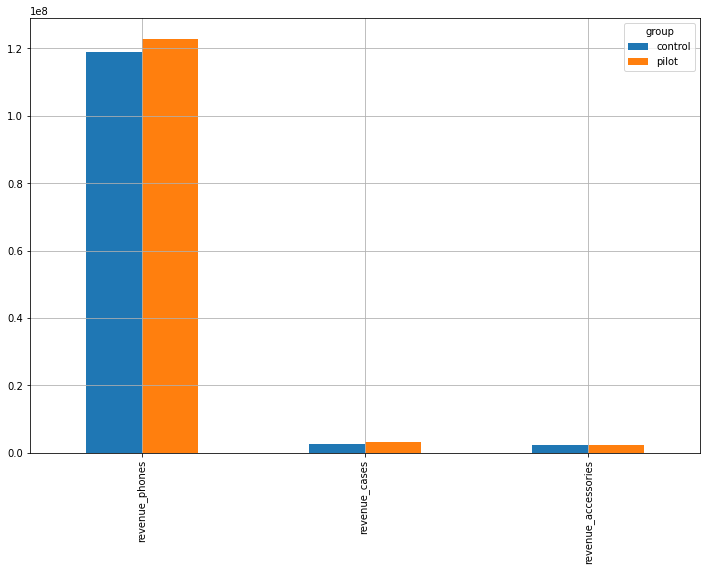

In [10]:
revenue = data_grouped[[col for col in data_grouped.columns if 'revenue' in col]].T
revenue.plot(kind='bar', grid=True)

График немного неинформативен из-за значительной разницы в масштабе. Но мы можем добавить магии matplotlib и симулировать разрыв в вертикальной оси:

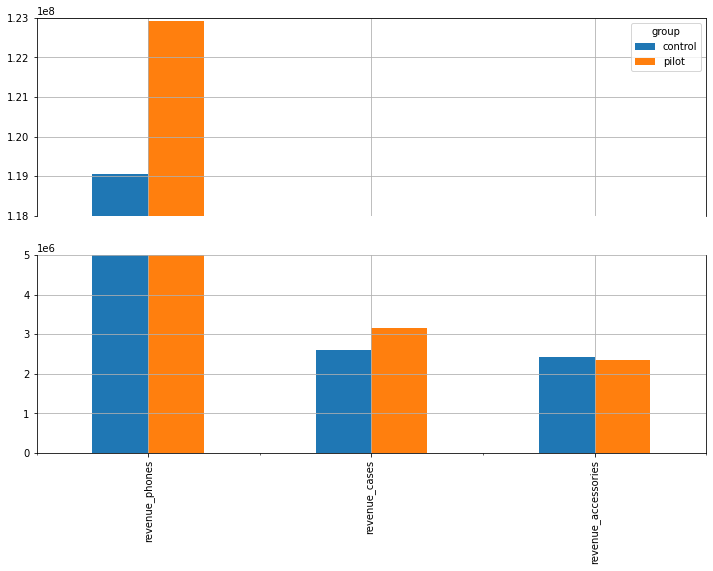

In [11]:
# https://stackoverflow.com/questions/53642861/broken-axis-slash-marks-inside-bar-chart-in-matplotlib

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 5 * 10 ** 6)
ax1.set_ylim(118 * 10 ** 6, 123 * 10 ** 6)

revenue.plot(ax=ax1, kind='bar', grid=True)
revenue.plot(ax=ax2, kind='bar', legend=False, grid=True)

Мы видим, что наша целевая метрика -- выручка по чехлам -- выросла. 
Немного просела выручка по аксессуарам, но падение незначительное.
Но главное в том, что значительно вырос основной показатель -- продажи мобильных телефонов. То есть цель выглядит достигнутой...

Так же мы можем посмотреть как на величину среднего чека, так и на средние значения по группам.

In [12]:
data_sint.groupby('group')[cost_columns].mean().astype(int)

,cost_phones,cost_cases,cost_accessories,cost_total,cost_associated
group,,,,,
control,37376,818,762,38957,1581
pilot,37622,969,719,39311,1688


Средний чек в пилотной группе меньше только по аксессуарам без учёта чехлов (cost_accessories), по остальным группам средний чек в пилотной группе стал больше.

## Проверка стат значимости

НО! Решения не принимаются на глаз. Человек склонен ошибаться и выдавать желаемое за действительное. Давайте считать статзначимость!

Проверим статистическую значимость отличий продаж по разным группам товаров.

Учтём, что в группах было по 110523 пользовательских сессий, а покупок чуть больше 3000 в каждой из групп. Соответственно, все сессии без покупок заполним нулями.

In [13]:
GROUP_SIZE = 110_523

for column in cost_columns:
    print(column)
    a_values_nonzero = data_sint[data_sint['group'] == 'control'][column].values
    b_values_nonzero = data_sint[data_sint['group'] == 'pilot'][column].values
    
    a_values = np.zeros(GROUP_SIZE)
    b_values = np.zeros(GROUP_SIZE)
    a_values[:len(a_values_nonzero)] = a_values_nonzero
    b_values[:len(b_values_nonzero)] = b_values_nonzero
    
    delta = b_values.mean() - a_values.mean()
    _, pvalue = stats.ttest_ind(a_values, b_values)
    print(f'  delta = {round(delta, 2)}')
    print(f'  pvalue = {round(pvalue, 3)}', '- значимо' if pvalue < 0.05 else '')

cost_phones
  delta = 35.02
  pvalue = 0.24 
cost_cases
  delta = 5.06
  pvalue = 0.0 - значимо
cost_accessories
  delta = -0.71
  pvalue = 0.533 
cost_total
  delta = 39.37
  pvalue = 0.202 
cost_associated
  delta = 4.35
  pvalue = 0.013 - значимо


Получили, что целевая метрика cost_cases_accessories статистически значимо увеличилась. Большинство контрольных метрик согласуются с гипотезой. Продажи прочих аксессуаров упали, но статистически не значимо, возможная причина - каннибализация. Это не критично, тк в сумме продажи прочих аксессуаров и чехлов выросли.

# 2. **Синтетические метрики - прогнозирование LTV**

Продвигаем игру для смартфонов, в которой есть встроенные покупки. Все покупки, как правило, делаются в первые три месяца игры. После трёх месяцев с момента установки что-то покупается крайне редко по имеющейся статистике.

Изменили рекламный контент, хотим сравнить как это повлияет на привлекаемых пользователей.

**Гипотеза:**
1. изменили рекламный контент
2. это привлечёт пользователей, с большим значением LTV
3. мы сможем это измерить по увеличевшемуся значению прогноза LTV

Ждать три месяца, чтобы посчитать реальный LTV мы не можем, это очень долго. Поэтому будем предсказывать LTV по информации накопленной о пользователе за первую неделю использования приложения.

**Пилот:**
- случайно разбиваем пользователей, которым показывается реклама, в контрольную или пилотную группы;
- в контрольной группе показываем старую рекламу, в пилотной - новую;
- ждём когда наберётся по 100_000 показов;
- конверсия в установки примерно 5%

## Загрузим данные

На этот раз нам потребуется загрузить три датасета. Воспользуемся ранее написанной функцией:

In [14]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name)

data_train_model = read_database('sem2_task2_train_model.csv')
data_control = read_database('sem2_task2_control.csv')
data_pilot = read_database('sem2_task2_pilot.csv')

dict_data = {
    'data_train_model': data_train_model,
    'data_control': data_control,
    'data_pilot': data_pilot
}

Посмотрим на данные:

In [15]:
for key, df in dict_data.items():
    print(f'\n.                {key}.shape = {df.shape}')
    print(df.head())


.                data_train_model.shape = (9871, 6)
   sale_first_week  game_time  game_days  bin_one  bin_two         ltv
0       234.202634        108          4        1        1  320.481732
1         0.000000         64          5        1        1   14.444559
2       100.708404         59          4        0        2  143.643114
3        73.543543        100          3        1        2  107.453755
4       168.911308         25          5        1        1  233.867330

.                data_control.shape = (4942, 5)
   sale_first_week  game_time  game_days  bin_one  bin_two
0          0.00000         77          4        1        2
1         55.97303        107          4        1        2
2          0.00000        103          4        0        3
3          0.00000         36          4        0        2
4          0.00000         69          5        0        2

.                data_pilot.shape = (4975, 5)
   sale_first_week  game_time  game_days  bin_one  bin_two
0        47.

При необходимости мы можем посмотреть на расширенную статистику.
Для числовых признаков pandas предоставляет данные по максимуму, минимуму, среднему значению, среднеквадратичному отклонению и квантилям:

In [16]:
data_train_model.describe()

,sale_first_week,game_time,game_days,bin_one,bin_two,ltv
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,73.779144,70.366528,4.207578,0.544220,1.491237,117.909658
std,82.655603,28.806035,1.284767,0.498066,0.865352,108.966714
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,50.000000,3.000000,0.000000,1.000000,22.269550
50%,46.185588,70.000000,4.000000,1.000000,1.000000,80.436254
75%,140.229993,90.000000,5.000000,1.000000,2.000000,204.276274
max,376.595154,171.000000,7.000000,1.000000,3.000000,512.356259


## Корреляция

Мы должны проверить свою гипотезу о связи ltv с покупками в первую неделю. Для этого можно рассмотреть корреляцию между ltv и остальными параметрами:

In [17]:
data_train_model.corrwith(data_train_model['ltv'])

sale_first_week    0.993046
game_time          0.010494
game_days          0.021826
bin_one           -0.001473
bin_two            0.005731
ltv                1.000000
dtype: float64

Мы видим, что корреляция между продажами в первую неделю и ltv близка к единице, это позволяет нам строить линейный прогноз. В целом же распределение продаж в первую неделю выглядит следующим образом:

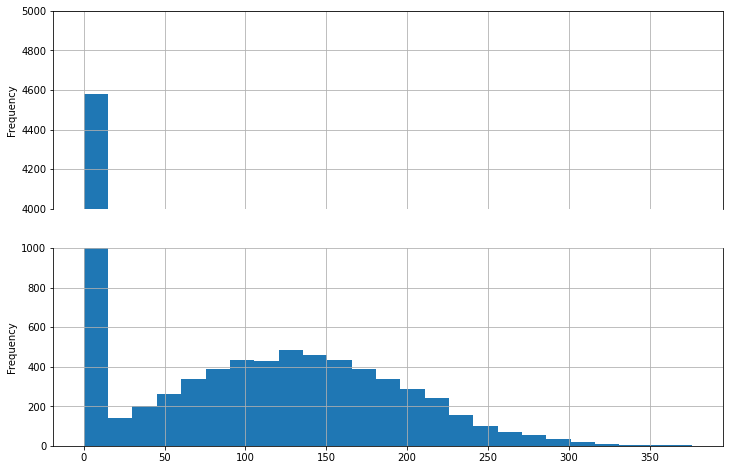

In [18]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 1000)
ax1.set_ylim(4000, 5000)

data_train_model['sale_first_week'].plot(ax=ax1, kind='hist', bins=25, grid=True)
data_train_model['sale_first_week'].plot(ax=ax2, kind='hist', bins=25, grid=True)

## Совместное распределение

Мы можем посмотреть как величины совместно распределениы. Для этого можно построить парные диаграммы рассеяния. Осторожно! Считается несколько минут!

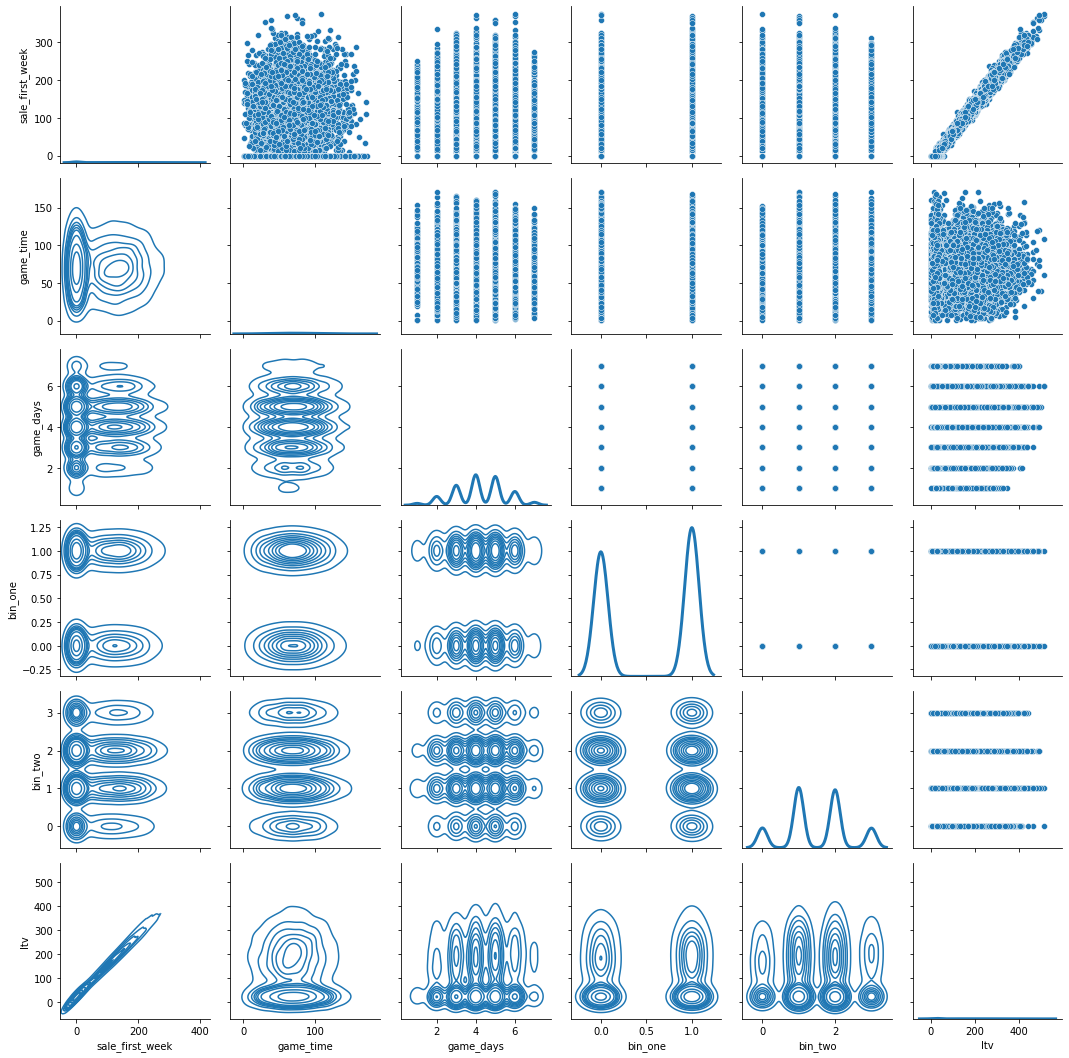

In [19]:
g = sns.PairGrid(data_train_model)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

## Сравнение параметров в контрольной и пилотной группах

In [20]:
for column in data_control.columns:
    print(column)
    delta = data_pilot[column].mean() - data_control[column].mean()
    _, pvalue = stats.ttest_ind(data_control[column], data_pilot[column])
    print(f'  delta = {round(delta, 4)}')
    print(f'  pvalue = {round(pvalue, 4)}', ' - значимо' if pvalue < 0.05 else '')

sale_first_week
  delta = 3.1515
  pvalue = 0.0548 
game_time
  delta = 9.8927
  pvalue = 0.0  - значимо
game_days
  delta = 0.3403
  pvalue = 0.0  - значимо
bin_one
  delta = -0.2081
  pvalue = 0.0  - значимо
bin_two
  delta = 0.5794
  pvalue = 0.0  - значимо


Видно, что параметры привлекаемых пользователей значимо изменились в пилотной группе. Хотя отличие наиболее скоррелированного с LTV параметра sale_first_week изменилось не статистически значимо.

## **Обучение модели**

Обучим линейную регрессию для предсказания LTV и попробуем проверить значимость отличий по получившейся модели.

Важно понимать, что мы делаем не абсолютно точное предсказание. Поэтому нам имеет смысл обучить несколько моделей и для лучшей из них проверить статзначимость. Таким образом мы уменьшаем возможные ошибки.

In [21]:
np.random.seed(2021)
train, test = train_test_split(data_train_model, test_size=0.2)


def train_model(features, train, test, verbose=True):
    model = RidgeCV(alphas=np.logspace(-8, 1, 10), normalize=True, cv=5)
    model.fit(train[features], train['ltv'])
    score = model.score(test[features], test['ltv'])
    if verbose:
        print(f'festures = {features}\tscore = {round(score, 5)}')

    return {'model': model, 'features': features, 'score': score}

features1 = ['sale_first_week', 'game_time', 'game_days']
features2 = ['sale_first_week', 'game_time', 'game_days', 'bin_one', 'bin_two']
features3 = ['sale_first_week', 'game_days', 'bin_one', 'bin_two']
features4 = ['sale_first_week', 'game_time', 'bin_one', 'bin_two']

trained_models = []

for features in [features1, features2, features3, features4]:
    trained_models.append(train_model(features, train, test))

festures = ['sale_first_week', 'game_time', 'game_days']	score = 0.98696
festures = ['sale_first_week', 'game_time', 'game_days', 'bin_one', 'bin_two']	score = 0.98705
festures = ['sale_first_week', 'game_days', 'bin_one', 'bin_two']	score = 0.98699
festures = ['sale_first_week', 'game_time', 'bin_one', 'bin_two']	score = 0.98656


Качество моделей получилось довольно хорошим. Сделаем прогнозы на данных пилотной и контрольной групп и сравним полученные прогнозные значения LTV для лучшей из наших моделей. Учтём, что реклама показывалась 100 тысячам пользователей, всех кто не устанавливал приложение заменим нулями.

In [22]:
trained_models.sort(key=lambda x: -x['score'])

def predict_and_calculate_ttest(model_and_properties, data_control, data_pilot):
    model = model_and_properties['model']
    features = model_and_properties['features']
    predict_control = model.predict(data_control[features])
    predict_pilot = model.predict(data_pilot[features])

    control_values = np.zeros(100_000)
    pilot_values = np.zeros(100_000)

    control_values[:len(predict_control)] = predict_control
    pilot_values[:len(predict_pilot)] = predict_pilot

    delta = pilot_values.mean() - control_values.mean()
    _, pvalue = stats.ttest_ind(control_values, pilot_values)

    print(f'delta = {round(delta, 4)}')
    print(f'pvalue = {round(pvalue, 4)}')

    return delta, pvalue

predict_and_calculate_ttest(trained_models[0], data_control, data_pilot)

delta = 0.348
pvalue = 0.0288


(0.3479932142537212, 0.028831949339781903)

Получили статистически значимое отличие прогнозных значений LTV.

При разнице в средних равной 0.348 на один показ рекламы, получаем для 100 тысяч показов прогнозируемый прирост LTV на 34800 рублей.

Заметим, что при близких результатах моделей модель худшего качества может не попасть в границы статистической значимости:

In [23]:
for trained_model in trained_models[1:]:
    print(f'\n\nfeatures : {trained_model["features"]}')
    predict_and_calculate_ttest(trained_model, data_control, data_pilot)



features : ['sale_first_week', 'game_days', 'bin_one', 'bin_two']
delta = 0.3269
pvalue = 0.0399


features : ['sale_first_week', 'game_time', 'game_days']
delta = 0.2952
pvalue = 0.063


features : ['sale_first_week', 'game_time', 'bin_one', 'bin_two']
delta = 0.3188
pvalue = 0.0449


In [24]:
import numpy as np
from scipy.stats import ttest_ind

In [25]:
p_vals = []
for _ in range(1000):
  # random_time_interval
  # random_a_b
  a = np.random.normal(0, 1, 100)
  b = np.random.normal(0 + 0.2, 1, 100)
  _, p_val = ttest_ind(a, b)
  p_vals.append(p_val)

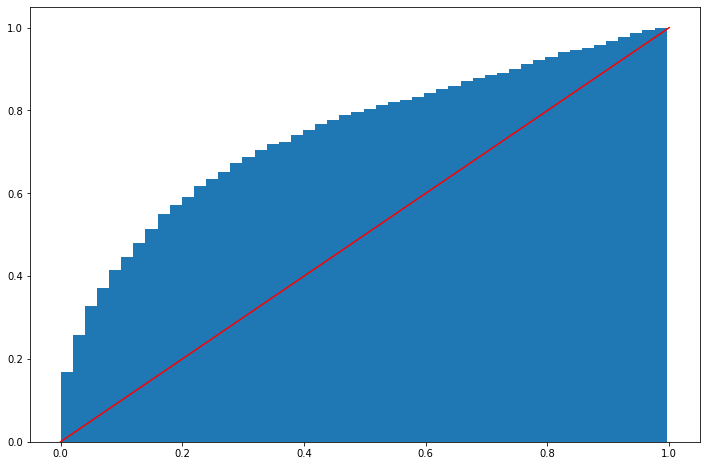

In [26]:
plt.hist(p_vals, cumulative=True, density=True, bins=50)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), c='r')